# The sbijax package

`Sbijax` is a Python package for neural simulation-based inference and approximate Bayesian computation. Here we implement the code in chapter~3 of the manuscript.

In [1]:
import jax
import sbijax
%matplotlib inline
import matplotlib.pyplot as plt

## 3.1 Model definition

To do approximate inference using `sbijax`, a user first has to define a prior model and a simulator function which can be used to generate synthetic data. We will be using a simple bivariate Gaussian as an example with the following generative model:

\begin{align}
\mu &\sim \mathcal{N}_2(0, I)\\
\sigma &\sim \mathcal{N}^+(1)\\
y & \sim \mathcal{N}_2(\mu, \sigma^2 I)
\end{align}

Using TensorFlow Probability, the prior model and simulator are implemented like this:

In [2]:
from jax import numpy as jnp, random as jr
from tensorflow_probability.substrates.jax import distributions as tfd

def prior_fn():
    prior = tfd.JointDistributionNamed(dict(
        mean=tfd.Normal(jnp.zeros(2), 1.0),
        scale=tfd.HalfNormal(jnp.ones(1)),
    ), batch_ndims=0)
    return prior

def simulator_fn(seed: jr.PRNGKey, theta: dict[str, jax.Array]):
    p = tfd.Normal(jnp.zeros_like(theta["mean"]), 1.0)
    y = theta["mean"] + theta["scale"] * p.sample(seed=seed)
    return y

In [3]:
prior = prior_fn()
theta = prior.sample(seed=jr.PRNGKey(0), sample_shape=())
theta

{'scale': Array([1.3508357], dtype=float32),
 'mean': Array([ 0.1579679, -0.8280125], dtype=float32)}

In [4]:
prior.log_prob(theta)

Array(-3.331326, dtype=float32)

In [5]:
simulator_fn(seed=jr.PRNGKey(1), theta=theta)

Array([1.0407865e-03, 2.1607199e+00], dtype=float32)

In [6]:
theta = prior.sample(seed=jr.PRNGKey(2), sample_shape=(2,))
theta

{'scale': Array([[0.40356722],
        [1.3396233 ]], dtype=float32),
 'mean': Array([[ 2.0789864 , -0.17086658],
        [ 1.5967263 , -0.89083904]], dtype=float32)}

In [7]:
prior.log_prob(theta)

Array([-4.3207917, -4.6325283], dtype=float32)

In [8]:
simulator_fn(seed=jr.PRNGKey(3), theta=theta)

Array([[ 1.7920444, -1.0935279],
       [ 1.9578097, -1.4624462]], dtype=float32)

## 3.2 Algorithm definition

Having defined a model of interest, i.e., the prior and simulator functions, we construct an inferential method.

In [9]:
import haiku as hk
import surjectors
import surjectors.nn
import surjectors.util
from sbijax import NLE

In [10]:
n_dim_data = 2
n_layers, hidden_sizes = 5, (64, 64)

In [11]:
def make_custom_affine_maf(n_dimension, n_layers, hidden_sizes):
    def _bijector_fn(params):
        means, log_scales = surjectors.util.unstack(params, -1)
        return surjectors.ScalarAffine(means, jnp.exp(log_scales))

    def _flow(method, **kwargs):
        layers = []
        order = jnp.arange(n_dimension)
        for _ in range(5):
            layer = surjectors.MaskedAutoregressive(
                bijector_fn=_bijector_fn,
                conditioner=surjectors.nn.MADE(
                    n_dimension, 
                    list(hidden_sizes), 
                    2,
                    w_init=hk.initializers.TruncatedNormal(0.001),
                    b_init=jnp.zeros,
                ),
            )
            order = order[::-1]
            layers.append(layer)
            layers.append(surjectors.Permutation(order, 1))
        chain = surjectors.Chain(layers[:-1])
        base_distribution = tfd.Independent(
            tfd.Normal(jnp.zeros(n_dimension), jnp.ones(n_dimension)),
            1,
        )
        td = surjectors.TransformedDistribution(base_distribution, chain)
        return td(method, **kwargs)

    td = hk.transform(_flow)
    return td

In [12]:
fns = prior_fn, simulator_fn
neural_network = make_custom_affine_maf(n_dim_data, n_layers, hidden_sizes)
model = NLE(fns, neural_network)

## 3.3 Training and Inference

Inference is then as easy as simulating some data, fitting the data to the model, a sampling from the approximate posterior. The data set is a dictionary of dictionaries (a PyTree in JAX lingo). It contains samples for the simulator function, called `y`, and parameter samples from the prior model, called `theta`.

In [13]:
data, _ = model.simulate_data(
    jr.PRNGKey(0),
    n_simulations=10_000,
)
data

{'y': Array([[-0.59566677,  0.6027423 ],
        [ 1.0860085 ,  0.87829024],
        [-1.5424889 , -1.037278  ],
        ...,
        [-0.07025349, -0.26872665],
        [-0.5158053 , -0.4318687 ],
        [-2.5512333 , -1.7580035 ]], dtype=float32),
 'theta': {'scale': Array([[0.6643912 ],
         [1.486737  ],
         [0.03883734],
         ...,
         [1.3584957 ],
         [0.05815173],
         [2.148177  ]], dtype=float32),
  'mean': Array([[-0.4190664 ,  0.8755527 ],
         [ 0.78585666, -0.7135212 ],
         [-1.5049669 , -0.95049435],
         ...,
         [ 1.395694  , -0.97918606],
         [-0.5161824 , -0.3568717 ],
         [-0.82899374,  0.25153396]], dtype=float32)}}

We then fit the model using the typical flow matching loss. 

In [14]:
params, losses = model.fit(jr.PRNGKey(2), data=data)

 13%|█████████████████▊                                                                                                                        | 129/1000 [00:33<03:48,  3.82it/s]


Finally, we sample from the posterior distribution for a specific observation $y_{\text{obs}}$.

In [25]:
y_obs = jnp.array([-1.0, 1.0])
inference_results, diagnostics = model.sample_posterior(
    jr.PRNGKey(2), params, y_obs
)

In [26]:
print(inference_results)

Inference data with groups:
	> posterior
	> observed_data


In [27]:
print(inference_results.posterior)

<xarray.Dataset> Size: 56kB
Dimensions:    (chain: 4, draw: 1000, mean_dim: 2, scale_dim: 1)
Coordinates:
  * chain      (chain) int64 32B 0 1 2 3
  * draw       (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * mean_dim   (mean_dim) int64 16B 0 1
  * scale_dim  (scale_dim) int64 8B 0
Data variables:
    mean       (chain, draw, mean_dim) float32 32kB -1.286 0.7951 ... 1.849
    scale      (chain, draw, scale_dim) float32 16kB 0.8144 1.029 ... 0.5558
Attributes:
    created_at:     2024-08-14T17:12:21.251521
    arviz_version:  0.17.1


## 3.4 Model diagnostics and visualization

`Sbijax` provides basic functionality to analyse posterior draws. We show some visualizations below.

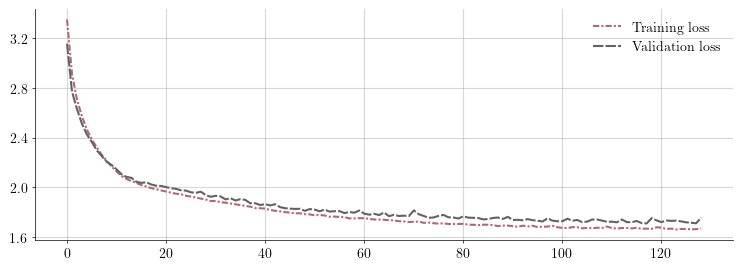

In [28]:
_, axes = plt.subplots(figsize=(9, 3))
sbijax.plot_loss_profile(losses[1:], axes=axes)
plt.show()

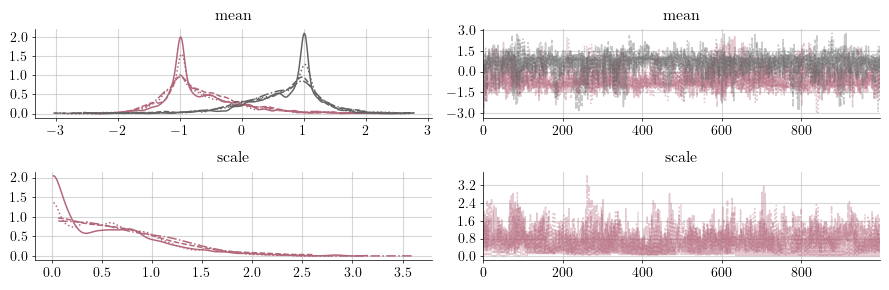

In [29]:
_, axes = plt.subplots(figsize=(9, 3), ncols=2, nrows=2)
sbijax.plot_trace(inference_results, axes=axes)
plt.show()

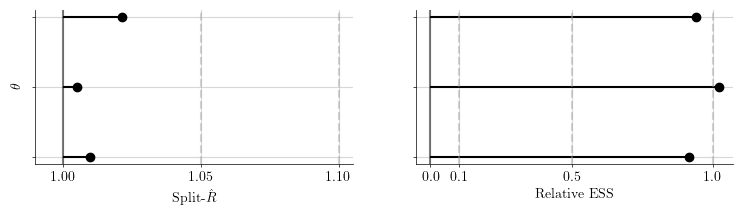

In [30]:
_, axes = plt.subplots(figsize=(9, 2), ncols=2)
sbijax.plot_rhat_and_ress(inference_results, axes)
plt.show()

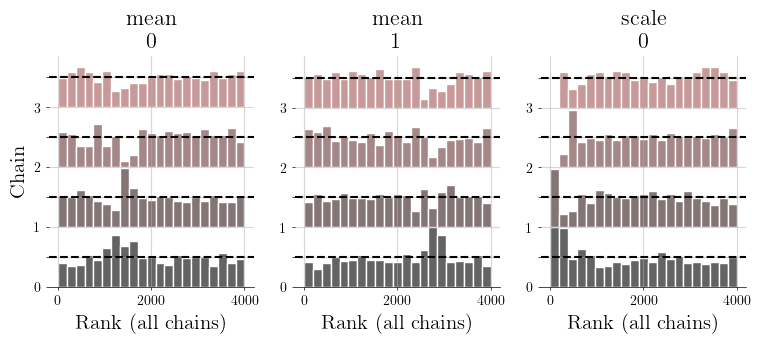

In [31]:
_, axes = plt.subplots(figsize=(9, 3), ncols=3)
sbijax.plot_rank(inference_results, axes)
plt.show()

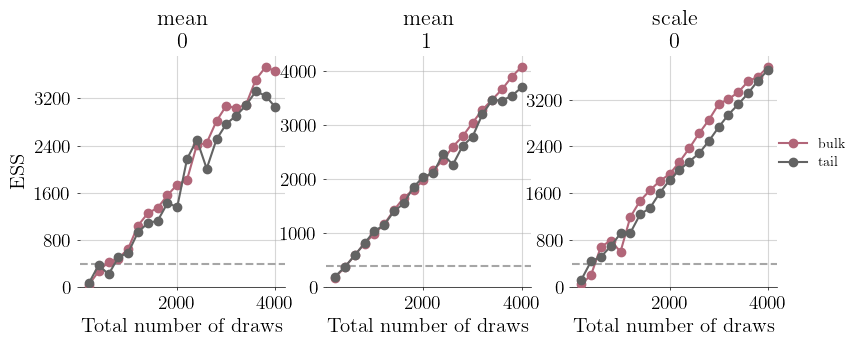

In [32]:
_, axes = plt.subplots(figsize=(9, 3), ncols=3)
sbijax.plot_ess(inference_results, axes)
plt.show()

## 3.5 Sequential inference

In [ ]:
from sbijax.util import stack_data

n_rounds = 5
data, params = None, {}
for i in range(n_rounds):
    new_data, _ = model.simulate_data(jr.fold_in(jr.PRNGKey(0), i),
        params=params,
        observable=y_obs,
        data=data,
    )
    data = stack_data(data, new_data)
    params, info = model.fit(jr.fold_in(jr.PRNGKey(1), i), data=data)

inference_results, diagnostics = model.sample_posterior(
    jr.PRNGKey(2), params, y_obs
)

  1%|█▋                                                                                                                                         | 12/1000 [00:03<03:30,  4.70it/s]

## Session info

In [24]:
import session_info

session_info.show(html=False)

-----
arviz                       0.17.1
haiku                       0.0.11
jax                         0.4.24
jaxlib                      0.4.24
matplotlib                  3.6.2
sbijax                      1.0.0
session_info                1.0.0
surjectors                  0.3.3
tensorflow_probability      0.24.0-dev20240224
-----
IPython             8.8.0
jupyter_client      7.4.9
jupyter_core        5.1.3
jupyterlab          3.5.2
notebook            6.5.2
-----
Python 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) [Clang 14.0.6 ]
macOS-13.0.1-arm64-arm-64bit
-----
Session information updated at 2024-08-14 19:12
